# Section 4 - Supervised Learning: Deep Learning

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore") # to ignore long warning messages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import pickle

## Load the data

In [2]:
# load with pandas
train_dataset = pd.read_csv('data/DL_train_dataset.csv')
# print the shape of the data (number of rows and columns)
print(train_dataset.shape)
# print the first 5 rows of the data
train_dataset.head()

(18442, 8780)


,Drug1_Standardized,Drug2_Standardized,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,...,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784,Y
0,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,...,0.434777,-0.708097,-0.799171,0.493310,-0.238066,1.277929,0.692556,-0.986860,-0.364915,7.693530
1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,...,0.870316,-0.551325,1.181514,0.945715,0.396515,1.239489,1.139748,-1.074747,-0.425887,7.778053
2,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,...,-0.494245,-0.641496,-0.349373,-0.035854,-1.268299,-0.276589,-0.421947,-1.069653,-1.004115,-1.198505
3,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,...,-2.382096,0.064357,-0.585589,-2.237517,-1.288513,-1.647860,-1.703751,-0.718126,0.636893,-5.139971
4,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,...,0.475517,2.008599,-0.213207,0.804718,-0.925362,0.575502,-0.350169,-1.020324,-0.867545,4.175936


In [3]:
# get genomic features train data
genomic_features_train = train_dataset.drop(['Drug1_Standardized', 'Drug2_Standardized', 'Y'], axis=1)
print(genomic_features_train.shape)
genomic_features_train.head()

(18442, 8777)


,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,Genomic_8,Genomic_9,...,Genomic_8775,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784
0,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.933798,0.434777,-0.708097,-0.799171,0.493310,-0.238066,1.277929,0.692556,-0.986860,-0.364915
1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.452877,0.870316,-0.551325,1.181514,0.945715,0.396515,1.239489,1.139748,-1.074747,-0.425887
2,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-0.367603,-0.494245,-0.641496,-0.349373,-0.035854,-1.268299,-0.276589,-0.421947,-1.069653,-1.004115
3,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-1.855299,-2.382096,0.064357,-0.585589,-2.237517,-1.288513,-1.647860,-1.703751,-0.718126,0.636893
4,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-0.744059,0.475517,2.008599,-0.213207,0.804718,-0.925362,0.575502,-0.350169,-1.020324,-0.867545


In [4]:
# get genomic features train data size
genomic_features_size = genomic_features_train.shape[1]

In [5]:
# load the test data
test_dataset = pd.read_csv('data/DL_test_dataset.csv')
print(test_dataset.shape)
test_dataset.head()

(4610, 8780)


,Drug1_Standardized,Drug2_Standardized,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,...,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784,Y
0,O=P1(N(CCCl)CCCl)NCCCO1,NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12,-0.189761,-0.198631,-0.189761,-0.960891,-0.398382,-0.189761,-0.189761,-1.395685,...,0.983524,-0.676135,-0.735852,-0.134726,-0.273893,-0.691539,1.226842,1.300643,1.716953,-66.134218
1,O=C(CCCCCCC(=O)Nc1ccccc1)NO,NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12,-0.189761,-0.198631,-0.189761,1.492552,-0.398382,-0.189761,-0.189761,-0.928305,...,0.800948,-0.841755,-1.242644,0.548545,0.368458,0.803943,0.030520,1.301387,1.694139,-3.809199
2,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,0.784357,...,-2.382095,0.064355,-0.585564,-2.237516,-1.288522,-1.647859,-1.703749,-0.718135,0.636911,14.652960
3,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,-1.021070,...,0.358498,-0.657769,-1.134156,0.004850,-1.349099,1.091526,-0.152564,1.363697,-0.967931,-16.204517
4,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC...,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,-1.021070,...,-2.382095,0.064334,-0.585529,-2.237516,-1.288540,-1.647866,-1.703749,-0.718133,0.636914,-17.080158


In [6]:
# get genomic features test data
genomic_features_test = test_dataset.drop(['Drug1_Standardized', 'Drug2_Standardized', 'Y'], axis=1)
print(genomic_features_test.shape)
genomic_features_test.head()

(4610, 8777)


,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,Genomic_8,Genomic_9,...,Genomic_8775,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784
0,-0.189761,-0.198631,-0.189761,-0.960891,-0.398382,-0.189761,-0.189761,-1.395685,-0.674233,-0.890960,...,0.518851,0.983524,-0.676135,-0.735852,-0.134726,-0.273893,-0.691539,1.226842,1.300643,1.716953
1,-0.189761,-0.198631,-0.189761,1.492552,-0.398382,-0.189761,-0.189761,-0.928305,-0.674233,-0.890960,...,-0.670516,0.800948,-0.841755,-1.242644,0.548545,0.368458,0.803943,0.030520,1.301387,1.694139
2,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,0.784357,-0.674233,1.650004,...,-1.855299,-2.382095,0.064355,-0.585564,-2.237516,-1.288522,-1.647859,-1.703749,-0.718135,0.636911
3,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,-1.021070,-0.674233,0.572001,...,-0.804505,0.358498,-0.657769,-1.134156,0.004850,-1.349099,1.091526,-0.152564,1.363697,-0.967931
4,-0.189761,-0.198631,-0.189761,0.905970,-0.398382,-0.189761,-0.189761,-1.021070,-0.674233,0.572001,...,-1.855299,-2.382095,0.064334,-0.585529,-2.237516,-1.288540,-1.647866,-1.703749,-0.718133,0.636914


In [7]:
y_train = train_dataset['Y']
y_test = test_dataset['Y']

## Data Preprocessing

To train the neural networks we needed to transform the smiles sequences into numerical features. To achieve that, we performed character encoding i.e. counting the number of occurences of each character in a smile string. We also performed sequences padding to make them all the same length.

### Character Encoding

In [8]:
# get lenghts of train SMILES using numpy
smiles_lengths_drug1 = np.array([len(smile) for smile in train_dataset.Drug1_Standardized])

In [9]:
# get lenghts of train SMILES using numpy
smiles_lengths_drug2 = np.array([len(smile) for smile in train_dataset.Drug2_Standardized])

In [10]:
# get the lengths at different percentiles
percentiles = [50, 75, 90, 95, 99, 100]
for percentile in percentiles:
    print('{} percentile: {} characters'.format(percentile, np.percentile(smiles_lengths_drug1, percentile)))

50 percentile: 54.0 characters
75 percentile: 66.0 characters
90 percentile: 109.0 characters
95 percentile: 112.0 characters
99 percentile: 127.0 characters
100 percentile: 127.0 characters


In [11]:
# get the lengths at different percentiles
percentiles = [50, 75, 90, 95, 99, 100]
for percentile in percentiles:
    print('{} percentile: {} characters'.format(percentile, np.percentile(smiles_lengths_drug2, percentile)))

50 percentile: 51.0 characters
75 percentile: 57.0 characters
90 percentile: 75.0 characters
95 percentile: 127.0 characters
99 percentile: 127.0 characters
100 percentile: 127.0 characters


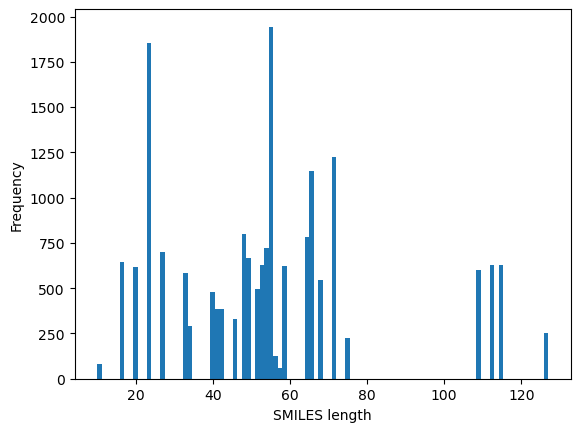

In [ ]:
# Plot histogram of SMILES lengths
plt.hist(smiles_lengths_drug1, bins=100)
plt.xlabel("SMILES length")
plt.ylabel("Frequency")
plt.show()

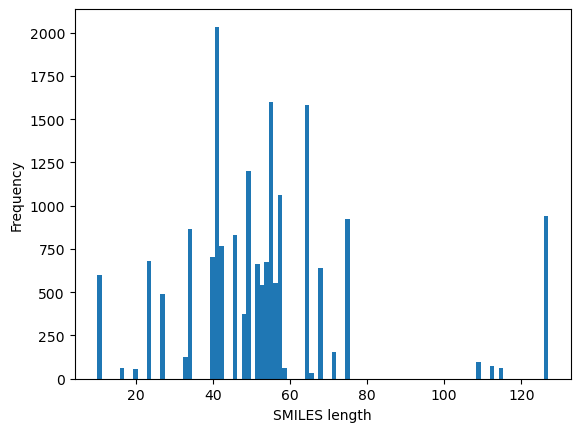

In [ ]:
# Plot histogram of SMILES lengths
plt.hist(smiles_lengths_drug2, bins=100)
plt.xlabel("SMILES length")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Tokenize the SMILES data
max_characters = 127  # Max length of SMILES notation
tokenizer_drug1 = Tokenizer(char_level=True, lower=False, oov_token="<UNK>") #out-of-vocabulary token is used to replace characters that are not in the vocabulary
tokenizer_drug1.fit_on_texts(train_dataset.Drug1_Standardized)

# Convert SMILES to sequences of integers
x_train_drug1 = tokenizer_drug1.texts_to_sequences(train_dataset.Drug1_Standardized)
x_test_drug1 = tokenizer_drug1.texts_to_sequences(test_dataset.Drug1_Standardized)

In [15]:
# Tokenize the SMILES data
tokenizer_drug2 = Tokenizer(char_level=True, lower=False, oov_token="<UNK>") #out-of-vocabulary token is used to replace characters that are not in the vocabulary
tokenizer_drug2.fit_on_texts(train_dataset.Drug2_Standardized)  #why we only fit on train data?

# Convert SMILES to sequences of integers
x_train_drug2 = tokenizer_drug2.texts_to_sequences(train_dataset.Drug2_Standardized)
x_test_drug2 = tokenizer_drug2.texts_to_sequences(test_dataset.Drug2_Standardized)

In [16]:
print('First SMILES string:', train_dataset.Drug1_Standardized[0])
print('Length of SMILES string:', len(train_dataset.Drug1_Standardized[0]))

print('SMILES converted to sequences of integers:', x_train_drug1[0])
print('Length of sequence:', len(x_train_drug1[0]))

First SMILES string: O=c1[nH]cc(F)c(=O)[nH]1
Length of SMILES string: 23
SMILES converted to sequences of integers: [6, 8, 3, 7, 16, 12, 18, 17, 3, 3, 4, 13, 5, 3, 4, 8, 6, 5, 16, 12, 18, 17, 7]
Length of sequence: 23


In [17]:
print('First SMILES string:', train_dataset.Drug2_Standardized[0])
print('Length of SMILES string:', len(train_dataset.Drug2_Standardized[0]))

print('SMILES converted to sequences of integers:', x_train_drug2[0])
print('Length of sequence:', len(x_train_drug2[0]))

First SMILES string: CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
Length of SMILES string: 34
SMILES converted to sequences of integers: [3, 3, 7, 4, 2, 8, 9, 2, 12, 2, 4, 3, 4, 11, 5, 10, 6, 5, 2, 2, 2, 2, 12, 17, 9, 20, 18, 8, 5, 3, 3, 3, 11, 7]
Length of sequence: 34


In [18]:
print(tokenizer_drug1.word_index)

{'<UNK>': 1, 'C': 2, 'c': 3, '(': 4, ')': 5, 'O': 6, '1': 7, '=': 8, '2': 9, 'N': 10, '3': 11, 'n': 12, 'F': 13, '4': 14, '5': 15, '[': 16, ']': 17, 'H': 18, 'l': 19, '-': 20, 'S': 21, '#': 22, '6': 23, 'P': 24, 's': 25, 'o': 26, 'I': 27, 'B': 28, '+': 29}


In [19]:
print(tokenizer_drug2.word_index)

{'<UNK>': 1, 'c': 2, 'C': 3, '(': 4, ')': 5, 'O': 6, '1': 7, '2': 8, 'n': 9, '=': 10, 'N': 11, '3': 12, '4': 13, '-': 14, 'F': 15, '5': 16, '[': 17, ']': 18, 'l': 19, 'H': 20, '#': 21, 'B': 22, 's': 23, 'r': 24, '+': 25, 'P': 26, 'I': 27, 'S': 28, 'o': 29, '6': 30}


### Padding Sequences

In [20]:
# Pad sequences to make them of the same length
x_train_drug1 = pad_sequences(x_train_drug1, maxlen=max_characters, padding='post', truncating='post')
x_test_drug1 = pad_sequences(x_test_drug1, maxlen=max_characters, padding='post', truncating='post')

In [21]:
# Pad sequences to make them of the same length
x_train_drug2 = pad_sequences(x_train_drug2, maxlen=max_characters, padding='post', truncating='post')
x_test_drug2 = pad_sequences(x_test_drug2, maxlen=max_characters, padding='post', truncating='post')

In [22]:
print('First SMILES string:', train_dataset.Drug1_Standardized[0])
print('Length os SMILES string:', len(train_dataset.Drug1_Standardized[0]))
print('SMILES converted to sequences of integers and padded:', x_train_drug1[0])
print('Length of encoded sequence:', len(x_train_drug1[0]))

print('\n\nFirst SMILES string:', train_dataset.Drug1_Standardized[1])
print('Length os SMILES string:', len(train_dataset.Drug1_Standardized[1]))
print('SMILES converted to sequences of integers and padded:', x_train_drug1[1])
print('Length of encoded sequence:', len(x_train_drug1[1]))

print('\n\nShape of padded sequences:', x_train_drug1.shape)

First SMILES string: O=c1[nH]cc(F)c(=O)[nH]1
Length os SMILES string: 23
SMILES converted to sequences of integers and padded: [ 6  8  3  7 16 12 18 17  3  3  4 13  5  3  4  8  6  5 16 12 18 17  7  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]
Length of encoded sequence: 127


First SMILES string: O=c1[nH]cc(F)c(=O)[nH]1
Length os SMILES string: 23
SMILES converted to sequences of integers and padded: [ 6  8  3  7 16 12 18 17  3  3  4 13  5  3  4  8  6  5 16 12 18 17  7  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  

In [23]:
print('First SMILES string:', train_dataset.Drug2_Standardized[0])
print('Length os SMILES string:', len(train_dataset.Drug2_Standardized[0]))
print('SMILES converted to sequences of integers and padded:', x_train_drug2[0])
print('Length of encoded sequence:', len(x_train_drug2[0]))

print('\n\nFirst SMILES string:', train_dataset.Drug2_Standardized[1])
print('Length os SMILES string:', len(train_dataset.Drug2_Standardized[1]))
print('SMILES converted to sequences of integers and padded:', x_train_drug2[1])
print('Length of encoded sequence:', len(x_train_drug2[1]))

print('\n\nShape of padded sequences:', x_train_drug2.shape)

First SMILES string: CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
Length os SMILES string: 34
SMILES converted to sequences of integers and padded: [ 3  3  7  4  2  8  9  2 12  2  4  3  4 11  5 10  6  5  2  2  2  2 12 17
  9 20 18  8  5  3  3  3 11  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]
Length of encoded sequence: 127


First SMILES string: CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
Length os SMILES string: 34
SMILES converted to sequences of integers and padded: [ 3  3  7  4  2  8  9  2 12  2  4  3  4 11  5 10  6  5  2  2  2  2 12 17
  9 20 18  8  5  3  3  3 11  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 

In [24]:
vocab_size_drug1 = len(tokenizer_drug1.word_index) + 1
vocab_size_drug2 = len(tokenizer_drug2.word_index) + 1
vocab_size_drug1, vocab_size_drug2, max_characters

(30, 31, 127)

## Normalization of the y variable 

In [25]:
# check labels information
train_dataset['Y'].describe()

count    18442.000000
mean         5.117212
std         22.902877
min       -326.464304
25%         -5.581255
50%          4.337603
75%         15.099934
max        179.123325
Name: Y, dtype: float64

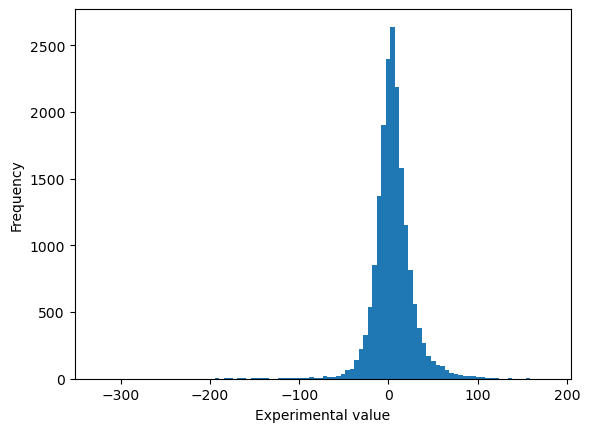

In [26]:
# plot labels values
plt.hist(train_dataset['Y'], bins=100)
plt.xlabel("Experimental value")
plt.ylabel("Frequency")
plt.show()

In [27]:
# Compute mean and standard deviation using only the training set
y_mean = np.mean(y_train)
y_std = np.std(y_train)

# Standardize y values
y_train_standardized = (y_train - y_mean) / y_std
y_test_standardized = (y_test - y_mean) / y_std

# Reshape standardized y_train and y_test to match input requirements
y_train = y_train_standardized.values.reshape(-1, 1)
print(y_train)
y_test = y_test_standardized.values.reshape(-1, 1)

[[ 0.11249189]
 [ 0.11618248]
 [-0.27576836]
 ...
 [ 0.67392554]
 [ 0.30883875]
 [ 0.31030039]]


We decided to build, train, and evaluate a recurrent neural network (RNN) and a convolutional neural network (CNN), both with multi inputs (tokenized drug1 and drug2 smiles, and genomic features preprocessed in section 1), to predict the synergy score.

## RNN - LSTM

In [29]:
def build_rnn_smiles_model(max_len, vocab_size_drug1, vocab_size_drug2, genomic_features_size):
    # Drug1 SMILES input
    input_drug1 = Input(shape=(max_len,), name="Drug1_SMILES")
    embedding_drug1 = Embedding(input_dim=vocab_size_drug1, output_dim=128, input_length=max_len)(input_drug1)
    rnn_drug1 = LSTM(128, return_sequences=True)(embedding_drug1)
    pooled_drug1 = GlobalMaxPooling1D()(rnn_drug1)

    # Drug2 SMILES input
    input_drug2 = Input(shape=(max_len,), name="Drug2_SMILES")
    embedding_drug2 = Embedding(input_dim=vocab_size_drug2, output_dim=128, input_length=max_len)(input_drug2)
    rnn_drug2 = LSTM(128, return_sequences=True)(embedding_drug2)
    pooled_drug2 = GlobalMaxPooling1D()(rnn_drug2)

    # Combine Drug1 and Drug2 features
    combined_smiles = Concatenate()([pooled_drug1, pooled_drug2])
    smiles_dense = Dense(128, activation="relu")(combined_smiles)

    # Define genomic descriptor input
    input_genomic = Input(shape=(genomic_features_size,), name="Genomic_Descriptors")
    genomic_dense = Dense(128, activation="relu")(input_genomic)

    # Combine SMILES and genomic descriptors
    combined_all = Concatenate()([smiles_dense, genomic_dense])

    # Fully connected layers
    dense1 = Dense(256, activation="relu")(combined_all)
    dropout1 = Dropout(0.3)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Output layer for regression
    output = Dense(1, activation="linear", name="Synergy_Score_Output")(dropout2)

    # Model definition
    model = Model(inputs=[input_drug1, input_drug2, input_genomic], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mse", "mae"])

    return model

In [30]:
rnn_model = build_rnn_smiles_model(max_characters, vocab_size_drug1, vocab_size_drug2, genomic_features_size)
rnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Drug1_SMILES        │ (None, 127)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Drug2_SMILES        │ (None, 127)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 127, 128)  │      3,840 │ Drug1_SMILES[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 127, 128)  │      3,968 │ Drug2_SMILES[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 127, 128)  │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 127, 128)  │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ lstm[0][0]        │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ lstm_1[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Genomic_Descriptors │ (None, 8777)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,123,584 │ Genomic_Descript… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Synergy_Score_Outp… │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,526,273 (5.82 MB)

 Trainable params: 1,526,273 (5.82 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define callbacks

# Stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(filepath='best_model_rnn.keras', monitor='val_loss', save_best_only=True)

In [32]:
# for reproducibility purposes we will fix the random seed

# Set a random seed
np.random.seed(24)
tf.random.set_seed(24)

In [33]:
# Train the model
history = rnn_model.fit([x_train_drug1, x_train_drug2, genomic_features_train], y_train,
                    epochs=100, batch_size=128,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_split=0.2)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 651ms/step - loss: 1.9369 - mae: 0.9640 - mse: 1.9369 - val_loss: 1.0471 - val_mae: 0.6670 - val_mse: 1.0471
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 69s 595ms/step - loss: 0.8505 - mae: 0.6033 - mse: 0.8505 - val_loss: 1.0202 - val_mae: 0.6647 - val_mse: 1.0202
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 67s 575ms/step - loss: 0.7729 - mae: 0.5644 - mse: 0.7729 - val_loss: 0.9993 - val_mae: 0.6615 - val_mse: 0.9993
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 69s 592ms/step - loss: 0.7247 - mae: 0.5465 - mse: 0.7247 - val_loss: 0.9651 - val_mae: 0.6433 - val_mse: 0.9651
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 66s 565ms/step - loss: 0.6889 - mae: 0.5257 - mse: 0.6889 - val_loss: 0.9742 - val_mae: 0.6512 - val_mse: 0.9742
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 73s 633ms/step - loss: 0.6492 - mae: 0.5152 - mse: 0.6492 - val_loss: 1.0633 - val_mae: 0.6948 - val_mse: 1.0633
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 72s 617ms/step - loss: 0.6277 - mae

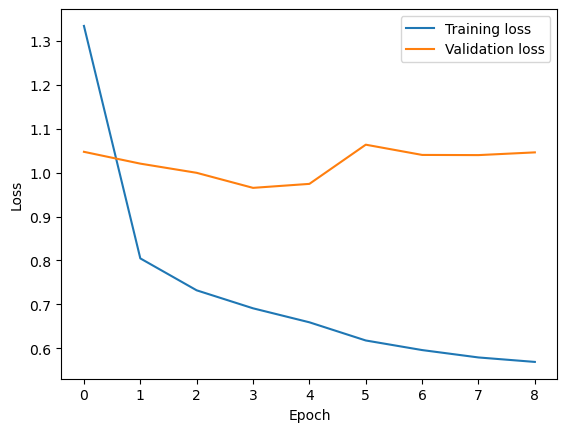

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Analyzing the graph above we can clearly see a great difference between the training loss and the validation loss curves, with the validation loss curve being relatively constant and higher than the training loss curve. This is a clear trend of overfitting, evidenced by the rising validation loss over epochs. This may be due to the model larger architecture causing a high number of parameters, increasing the risk of overfitting on the training data, leading to better performance on training but poor generalization to validation data.

In [ ]:
# load the best model
rnn_model.load_weights('best_model_rnn.keras')

# Evaluate the model on the test set
loss, mse, mae = rnn_model.evaluate([x_test_drug1, x_test_drug2, genomic_features_test], y_test)
loss, mse, mae

145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.6570 - mae: 0.5290 - mse: 0.6570


(0.7798734903335571, 0.7798734903335571, 0.5725147724151611)

Here we can visualize the scores for our model on the test set, resulting in too high values of MSE (0.780) when compared to literature (255.49).

145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step


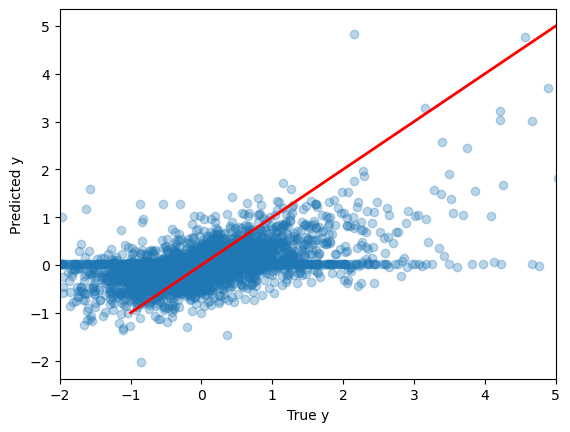

In [36]:
# plot the predicted vs. true y values
y_pred = rnn_model.predict([x_test_drug1, x_test_drug2, genomic_features_test])
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([-1, 5], [-1, 5], color='red', linestyle='-', linewidth=2)
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.xlim(-2, 5)
plt.show()

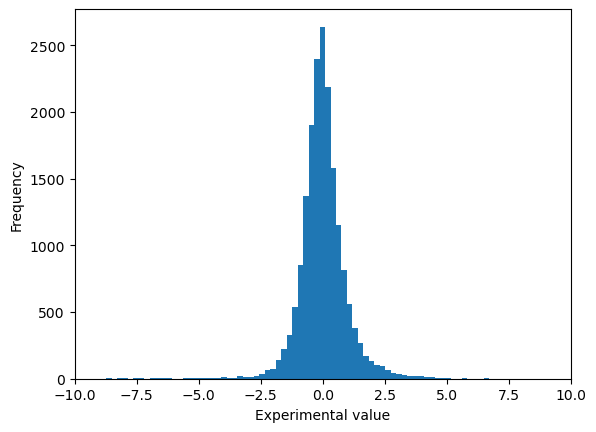

In [ ]:
# plot distribution of y_train
plt.hist(y_train, bins=100)
plt.xlabel("Experimental value")
plt.ylabel("Frequency")
plt.xlim(-10, 10)
plt.show()

In [38]:
# save the model and tokenizer
rnn_model.save('rnn_model.keras')
with open('tokenizer_drug1.pickle', 'wb') as handle:
    pickle.dump(tokenizer_drug1, handle)
with open('tokenizer_drug2.pickle', 'wb') as handle:
    pickle.dump(tokenizer_drug2, handle)

## CNN

In [40]:
def build_cnn_smiles_model(max_len, vocab_size_drug1, vocab_size_drug2, genomic_features_size):
    # Drug1 SMILES input
    input_drug1 = Input(shape=(max_len,), name="Drug1_SMILES")
    embedding_drug1 = Embedding(input_dim=vocab_size_drug1, output_dim=128, input_length=max_len)(input_drug1)
    cnn_drug1 = Conv1D(64, kernel_size=3, activation="relu")(embedding_drug1)
    pooled_drug1 = GlobalMaxPooling1D()(cnn_drug1)

    # Drug2 SMILES input
    input_drug2 = Input(shape=(max_len,), name="Drug2_SMILES")
    embedding_drug2 = Embedding(input_dim=vocab_size_drug2, output_dim=128, input_length=max_len)(input_drug2)
    cnn_drug2 = Conv1D(64, kernel_size=3, activation="relu")(embedding_drug2)
    pooled_drug2 = GlobalMaxPooling1D()(cnn_drug2)

    # Combine Drug1 and Drug2 features
    combined_smiles = Concatenate()([pooled_drug1, pooled_drug2])
    smiles_dense = Dense(128, activation="relu")(combined_smiles)

    # Define genomic descriptor input
    input_genomic = Input(shape=(genomic_features_size,), name="Genomic_Descriptors")
    genomic_dense = Dense(128, activation="relu")(input_genomic)

    # Combine SMILES and genomic descriptors
    combined_all = Concatenate()([smiles_dense, genomic_dense])

    # Fully connected layers
    dense1 = Dense(256, activation="relu")(combined_all)
    dropout1 = Dropout(0.3)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Output layer for regression
    output = Dense(1, activation="linear", name="Synergy_Score_Output")(dropout2)

    # Model definition
    model = Model(inputs=[input_drug1, input_drug2, input_genomic], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mse", "mae"])

    return model

In [41]:
cnn_model = build_cnn_smiles_model(max_characters, vocab_size_drug1, vocab_size_drug2, genomic_features_size)
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Drug1_SMILES        │ (None, 127)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Drug2_SMILES        │ (None, 127)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 127, 128)  │      3,840 │ Drug1_SMILES[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 127, 128)  │      3,968 │ Drug2_SMILES[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 125, 64)   │     24,640 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 64)   │     24,640 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Genomic_Descriptors │ (None, 8777)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │  1,123,584 │ Genomic_Descript… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Synergy_Score_Outp… │ (None, 1)         │        129 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,296,001 (4.94 MB)

 Trainable params: 1,296,001 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(filepath='best_model_cnn.keras', monitor='val_loss', save_best_only=True)

cnn_model.fit([x_train_drug1, x_train_drug2, genomic_features_train], y_train, validation_split=0.3, epochs=100, batch_size=128,
          callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - loss: 1.5540 - mae: 0.8857 - mse: 1.5540 - val_loss: 1.0493 - val_mae: 0.6424 - val_mse: 1.0493
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.7693 - mae: 0.5832 - mse: 0.7693 - val_loss: 1.1238 - val_mae: 0.6793 - val_mse: 1.1238
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.6867 - mae: 0.5468 - mse: 0.6867 - val_loss: 1.1802 - val_mae: 0.7086 - val_mse: 1.1802
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.6385 - mae: 0.5287 - mse: 0.6385 - val_loss: 1.2157 - val_mae: 0.7268 - val_mse: 1.2157
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.5951 - mae: 0.5074 - mse: 0.5951 - val_loss: 1.3058 - val_mae: 0.7632 - val_mse: 1.3058
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.5711 - mae: 0.5034 - mse: 0.5711 - val_loss: 1.1567 - val_mae: 0.7014 - val_mse: 1.1567


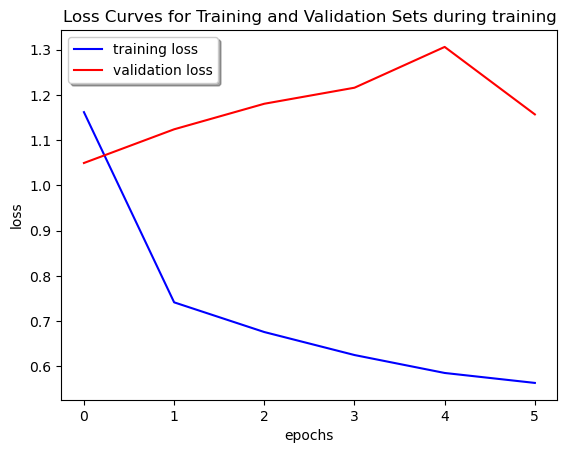

In [ ]:
# Plot the loss and accuracy curves for training and validation
plt.plot(cnn_model.history.history['loss'], color='b', label="training loss")
plt.plot(cnn_model.history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curves for Training and Validation Sets during training')
plt.show()

Like in the RNN, the CNN also resulted likely in overfitting.

In [ ]:
# Load the best model
cnn_model = keras.models.load_model('best_model_cnn.keras')
loss, mse, mae = cnn_model.evaluate([x_test_drug1, x_test_drug2, genomic_features_test], y_test)
loss, mse, mae

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7850 - mae: 0.5750 - mse: 0.7850


(0.8755580186843872, 0.8755580186843872, 0.6071878671646118)

The same can be said for the CNN with MSE value of (0.780) way higher than the literature (255.49).

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


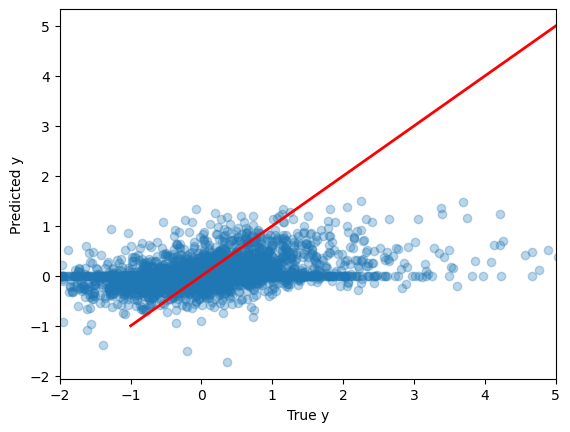

In [ ]:
# plot the predicted vs. true y values
y_pred = cnn_model.predict([x_test_drug1, x_test_drug2, genomic_features_test])
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([-1, 5], [-1, 5], color='red', linestyle='-', linewidth=2)
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.xlim(-2, 5)
plt.show()

In [48]:
# save the model
cnn_model.save('cnn_model.keras')

General conclusions:

Our results were substantially worse when compared with literature, which indicates that these models have potential, and would benefit from an optimization.

Our data as a very high number of features (more than 8000) which introduces complexity to the models and often leads to overfitting. More preprocessing such as feature reduction or selection would be a means to try to solve this issue.

Another problem could be the very different data that is being used to train the models, since we are mixing in the same neural network tokenized smiles and genomic features/descriptors, that have a very different data structure, which can make the models struggle to learn effectively, leading to higher loss values.

## References

[https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false](https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false)

[2]	K. Preuer, R. P. I. Lewis, S. Hochreiter, A. Bender, K. C. Bulusu, and G. Klambauer, “DeepSynergy: predicting anti-cancer drug synergy with Deep Learning,” Bioinformatics, vol. 34, no. 9, pp. 1538–1546, May 2018, doi: 10.1093/bioinformatics/btx806
